# Imports

In [1]:
import random
import numpy as np
import pandas as pd
import os
import cv2
import shutil
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
from argparse import Namespace
import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torchvision
import torchvision.transforms.functional as tf
from torchvision.models.detection.ssd import SSDHead,det_utils
from torchvision.models.detection import ssd300_vgg16
from torchvision.models.detection import SSD300_VGG16_Weights
import pycocotools
import torchmetrics
from torchmetrics.detection import MeanAveragePrecision

warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
!pip install pycocotools -q

# Dataset Structure

In [3]:
#! rm -rf "/kaggle/working/data"
#! rm -rf "/kaggle/working/output"

In [4]:
# root directory
!mkdir "/kaggle/working/data"

# images directory 
!mkdir "/kaggle/working/data/images"

# train and test subdirectories with image directory
!mkdir "/kaggle/working/data/images/train"
!mkdir "/kaggle/working/data/images/val"

# labels directory
!mkdir "/kaggle/working/data/labels"

# train and test subdirectories with labels directory
!mkdir "/kaggle/working/data/labels/train"
!mkdir "/kaggle/working/data/labels/val"

# output directory
!mkdir "/kaggle/working/output"
!mkdir "/kaggle/working/output/models"
!mkdir "/kaggle/working/output/results"

# Configuration

In [5]:
#config.py
config=Namespace(TRAIN_IMG_DIR="/kaggle/working/data/images/train",
                 TRAIN_IMG_ANNOTATION="/kaggle/working/data/labels/train",
                 VAL_IMG_DIR="/kaggle/working/data/images/val",
                 VAL_IMG_ANNOTATION="/kaggle/working/data/labels/val",
                 OUTPUT_DIR="/kaggle/working/output",
                 OUTPUT_DIR_MODELS="/kaggle/working/output/models",
                 OUTPUT_DIR_PYTORCH_WEIGHTS="/kaggle/working/output/models/checkpoint.pth",
                 OUTPUT_DIR_ONNX_WEIGHTS="/kaggle/working/output/models/onnx_32_pth.onnx",
                 OUTPUT_DIR_QUANTIZED_WEIGHTS="/kaggle/working/output/models/onnx_quant_pth.onnx",
                 OUTPUT_DIR_RESULTS="/kaggle/working/output/results",
                 epochs=60,
                 batch_size=8,
                 trainable_layers=4,
                 learning_rate=1e-5,
                 patience=10,
                 min_delta=1,
                 factor=0.3,
                 size=768,
                 threshold=0.25,
                 iou_threshold=0.50,
                 classes=["background","face"],
                 device="cuda" if torch.cuda.is_available() else "cpu",
                 verbose=True)

# Dataset
**https://www.kaggle.com/datasets/iamprateek/wider-face-a-face-detection-dataset**

In [6]:
train_img_dir="/kaggle/input/wider-face-a-face-detection-dataset/WIDER_train/WIDER_train/images"
val_img_dir="/kaggle/input/wider-face-a-face-detection-dataset/WIDER_val/WIDER_val/images"
train_annot_dir="/kaggle/input/wider-face-a-face-detection-dataset/wider_face_annotations/wider_face_split/wider_face_train_bbx_gt.txt"
val_annot_dir="/kaggle/input/wider-face-a-face-detection-dataset/wider_face_annotations/wider_face_split/wider_face_val_bbx_gt.txt"
data_dir="/kaggle/working/data"

### Data Validation

In [7]:
#data_validation.py
def check_img_has_annotation(imgs_dir,img_annotation_file):
    annotated_img_files=set()
    with open(img_annotation_file,'r') as f:
        bbox_annotation=f.readlines()
    
    for i,line in enumerate(bbox_annotation):
        try:
            filename=line.replace("\n","")
            if filename.split("/")[-1].split(".")[-1]=="jpg":
                img_name=filename.split("/")[-1]
                annotated_img_files.add(img_name)
        except:
            continue

    datasplit_img_files=set()
    for folder in os.listdir(imgs_dir):
        folder_pth=os.path.join(imgs_dir,folder)
        for img_name in os.listdir(folder_pth):
            datasplit_img_files.add(img_name)
            
    if sorted(list(annotated_img_files))==sorted(list(datasplit_img_files)):
        print("There are annotation file for each image file")
    else:
        print("There are images missing annotation file:\n") 

In [8]:
check_img_has_annotation(train_img_dir,train_annot_dir)

There are annotation file for each image file


In [9]:
check_img_has_annotation(val_img_dir,val_annot_dir)

There are annotation file for each image file


### Organizing Data

In [10]:
 #preprocessing.py
def organizing_data(img_dir,img_annotation_file,data_dir,split):
     image_file_index=[]
     
     with open(img_annotation_file,'r') as f:
        bbox_annotation=f.readlines()
         
     for index,line in enumerate(bbox_annotation):
         try:
             if line.replace("\n","").split("/")[-1].split(".")[-1]=="jpg":
                 image_file_index.append(index)
         except:
             continue

     print(f"Organizing {split} Data\n")
     for i in tqdm(range(len(image_file_index))):
         
         img_filename=bbox_annotation[image_file_index[i]].replace("\n","")
         img_name=img_filename.split("/")[-1]
         annot_filename=img_name[:-4] + ".txt"
         
         img_pth=os.path.join(img_dir,img_filename)
         new_img_pth=os.path.join(data_dir,"images",split,img_name)
         annot_file_pth=os.path.join(data_dir,"labels",split,annot_filename)
         
         img_shape=cv2.imread(img_pth).shape
         
         start=image_file_index[i]+2
         if i!=len(image_file_index)-1:
             end=image_file_index[i+1]
         else:
             end=len(bbox_annotation)
             
         boxes=bbox_annotation[start:end]
         valid_bbox=valid_bbox_check(boxes,img_shape[0],img_shape[1])
         
         if len(valid_bbox)>0:
             shutil.copy(img_pth,new_img_pth)
             np.savetxt(annot_file_pth,valid_bbox, delimiter=',')
                 
def valid_bbox_check(boxes,height,width):
    valid_boxes=[]
    for box in boxes:
        box=list(map(float,box.split(" ")[:4]))
        if 0<box[0]<width and 0<box[2]<=width:
            if 0<box[1]<height and 0<box[3]<=height:
                valid_boxes.append(box)

    valid_boxes=np.array(valid_boxes)
    if reject_small_bbox(valid_boxes):
        return valid_boxes
    else:
        return []

def reject_small_bbox(boxes):
    try:
        area=(boxes[:,3])*(boxes[:,2])
        if (area>32*32).all():
            return True
        else:
            return False
    except:
        return False

In [11]:
organizing_data(train_img_dir,train_annot_dir,data_dir,split="train")

Organizing train Data



100%|██████████| 12880/12880 [02:48<00:00, 76.51it/s]


In [12]:
len(os.listdir(config.TRAIN_IMG_DIR))

8334

In [13]:
organizing_data(val_img_dir,val_annot_dir,data_dir,split="val")

Organizing val Data



100%|██████████| 3226/3226 [00:41<00:00, 77.76it/s]


In [14]:
len(os.listdir(config.VAL_IMG_DIR))

2063

# Dataset

In [15]:
#dataset.py

class FaceDetection(Dataset):
    def __init__(self,img_dir,annot_dir,transform=None):
        super().__init__()
        self.img_dir=img_dir
        self.annot_dir=annot_dir
        self.transform=transform
        self.img_list=sorted(list(os.listdir(self.img_dir)))

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self,idx):
        img_name=self.img_list[idx]
        annot_name=img_name[:-4]+".txt"
        
        img_pth=os.path.join(self.img_dir,img_name)
        annot_pth=os.path.join(self.annot_dir,annot_name)

        img=cv2.imread(img_pth)
        img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

        boxes,labels=get_annotation(annot_pth)
        area=(boxes[:,3]-boxes[:,1])*(boxes[:,2]-boxes[:,0])
        
        img=tf.to_tensor(img)
        img=img.to(dtype=torch.float32)
        target={}
        target["boxes"]=torch.tensor(boxes,dtype=torch.float32)
        target["labels"]=torch.tensor(labels,dtype=torch.int64)
        target["id"]=torch.tensor(idx)
        target["area"]=torch.tensor(area)
        
        return img,target

def get_annotation(annot_pth):
    annotation=np.loadtxt(annot_pth,delimiter=",")
    if len(annotation.shape)==1:
        annotation=annotation[None,:]

    annotation[:,2:]=annotation[:,:2]+annotation[:,2:]
    annotation_labels=np.ones(len(annotation),dtype=np.int64)
            
    return annotation,annotation_labels

def get_dataloader(img_dir,annot_dir,shuffle=False):
    dataset=FaceDetection(img_dir,annot_dir)
    dataloader=DataLoader(dataset,batch_size=config.batch_size,shuffle=shuffle,
                          num_workers=os.cpu_count(),collate_fn=collate_fn,
                          pin_memory=True if torch.cuda.is_available() else False)
    return dataloader

def collate_fn(batch):
    return tuple(zip(*batch))

# Model

In [16]:
#model.py
def get_model():
    weights=SSD300_VGG16_Weights.DEFAULT
    model=ssd300_vgg16(weights=weights,
                       trainable_backbone_layers=config.trainable_layers)
    in_channels=det_utils.retrieve_out_channels(model.backbone,(config.size,config.size))
    num_anchors=model.anchor_generator.num_anchors_per_location()
    model.head=SSDHead(in_channels=in_channels,num_anchors=num_anchors,
                       num_classes=len(config.classes))
    model.transform.min_size=(config.size,)
    model.transform.max_size=config.size
    model.to(config.device)
    return model

def get_optimizer(model):
    parameters=[params for params in model.parameters() if params.requires_grad==True]
    optimizer=optim.Adam(parameters,lr=config.learning_rate)
    return optimizer

# Utility

In [17]:
#utils.py

def set_seeds():
    random.seed(42)
    np.random.seed(42)
    torch.manual_seed(42)
    torch.backends.cudnn.deterministic=True
    
class EarlyStoping():
    def __init__(self,model,output_dir,patience=7,min_delta=0.0):
        self.best_loss=float("inf")
        self.counter=0
        self.patience=patience
        self.min_delta=min_delta
        self.model=model
        self.output_dir=output_dir
        
    def step(self,loss):
        if loss+self.min_delta<self.best_loss:
            self.best_loss=loss
            self.counter=0
            print("Updating Model Weights\n")
            torch.save(self.model.state_dict(),self.output_dir)
        else:
            self.counter+=1
            print(f"Early Stopping Counter:{self.counter} of {self.patience}\n")
            if self.counter>=self.patience:
                return True
        return False

class LrScheduler():
    def __init__(self,model,optimizer,patience,threshold,factor):
        self.model=model
        self.optimizer=optimizer
        self.learning_rate=self._get_current_lr()
        self.scheduler=optim.lr_scheduler.ReduceLROnPlateau(optimizer,mode='min',factor=factor,patience=patience,
                                                            threshold=threshold,threshold_mode="abs")
    def step(self,validation_loss):
        self.scheduler.step(validation_loss)
        if self.learning_rate!=self._get_current_lr():
            print(f"{self.learning_rate}\n")
            self.learning_rate=self._get_current_lr()
            print(f"{self.learning_rate}\n")
            print("Loading best Model weights\n")
            weights=torch.load(config.OUTPUT_DIR_PYTORCH_WEIGHTS,map_location=config.device)
            model.load_state_dict(weights)

    def _get_current_lr(self):
        for params in self.optimizer.param_groups:
            return params["lr"]
            
def nms_suppression_bbox(prediction):
    
    processed_bbox={}
    
    boxes=prediction["boxes"][prediction["scores"]>=config.threshold]
    scores=prediction["scores"][prediction["scores"]>=config.threshold]
    labels=prediction["labels"][prediction["scores"]>=config.threshold]
    nms=torchvision.ops.nms(boxes,scores,iou_threshold=config.iou_threshold)
            
    processed_bbox["boxes"]=boxes[nms]
    processed_bbox["scores"]=scores[nms]
    processed_bbox["labels"]=labels[nms]
    
    return processed_bbox

def box_iou_batch(boxes_a,boxes_b):
    def box_area(box):
        return (box[2]-box[0])*(box[3]-box[1])

    area_a=box_area(boxes_a.T)
    area_b=box_area(boxes_b.T)

    top_left=torch.maximum(boxes_a[:, None, :2], boxes_b[:, :2])
    bottom_right=torch.minimum(boxes_a[:, None, 2:], boxes_b[:, 2:])

    area_inter=torch.prod(np.clip(bottom_right - top_left,a_min=0,a_max=None), dim=2)
        
    return area_inter/(area_a[:, None]+area_b-area_inter)
    
def get_img_tensor(img_pth):
    img=cv2.imread(img_pth)
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img_tensor=tf.to_tensor(img)
    img_tensor=img_tensor.to(dtype=torch.float32,device=config.device)
    return img_tensor

def save_loss_plot(training_loss,validation_loss):
    plt.plot(training_loss,label='train')
    plt.plot(validation_loss,label='val')
    plt.title("Training Validation Loss Plot")
    plt.legend()
    loss_plot_pth=os.path.join(config.OUTPUT_DIR_RESULTS,"training_validation_loss.jpg")
    plt.savefig(loss_plot_pth)

def face_detection_visualization(img_tensor,target,color=(0,255,0)):
    img=np.transpose(img_tensor.cpu().numpy(),(1,2,0))
    img_detect=img.copy()
    
    try:
        boxes=target["boxes"].cpu().numpy().astype("int")
        scores=target["scores"].cpu().numpy()
        for i,box in enumerate(boxes):
            cv2.rectangle(img_detect,(box[0],box[1]),(box[2],box[3]),color,2)
            text=f"{scores[i]:.2f}"
            y=box[1]-10 if box[1]-10>10 else box[1]+10
            cv2.putText(img_detect,text,(box[0],y),cv2.FONT_HERSHEY_SIMPLEX,0.5,color,2)
    except:
        print("No Face Detected in the image\n")
        
    return img_detect

# Training

In [18]:
#train.py

def training_pipeline():
    lr_scheduler=LrScheduler(model,optimizer,patience=config.patience//2,threshold=config.min_delta,
                             factor=config.factor)
    early_stopping=EarlyStoping(model,config.OUTPUT_DIR_PYTORCH_WEIGHTS,patience=config.patience,
                                min_delta=config.min_delta)
    losses={"training_loss":[],
            "validation_loss":[]}
    
    for epoch in tqdm(range(config.epochs)):
        training_loss=one_epoch_train(model,train_dataloader,optimizer)
        validation_loss=one_epoch_val(model,val_dataloader,optimizer)

        losses["training_loss"].append(training_loss)
        losses["validation_loss"].append(validation_loss)
        
        if config.verbose:
            print(f"Training Loss for {epoch+1}: {training_loss:.2f}")
            print(f"Validation Loss for {epoch+1}: {validation_loss:.2f}\n")
            
        lr_scheduler.step(validation_loss)
        if early_stopping.step(validation_loss):
            break

    save_loss_plot(losses["training_loss"],losses["validation_loss"]) 
    
def one_epoch_train(model,dataloader,optimizer):
    training_loss=0
    
    model.train()
    for imgs,targets in dataloader:
        imgs=[img.to(config.device) for img in imgs]
        targets=[{k:v.to(config.device) for (k,v) in d.items()} for d in targets]

        loss_dict=model(imgs,targets)
        losses=sum(loss for loss in loss_dict.values())
        training_loss+=losses.item()
        
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

    return training_loss

def one_epoch_val(model,dataloader,optimizer):
    validation_loss=0
    
    for imgs,targets in dataloader:
        imgs=[img.to(config.device) for img in imgs]
        targets=[{k:v.to(config.device) for (k,v) in d.items()} for d in targets]

        with torch.no_grad():
            loss_dict=model(imgs,targets)
        losses=sum(loss for loss in loss_dict.values())
        validation_loss+=losses.item()
    
    return validation_loss

# Evaluation

In [19]:
#evaluate.py

def evaluate():
    map_metric=get_map_metric()
    dataloader=get_dataloader(config.VAL_IMG_DIR,config.VAL_IMG_ANNOTATION)
    
    for imgs,targets in tqdm(dataloader):
        imgs=[img.to(config.device) for img in imgs]
        targets=[{k:v.to(config.device) for (k,v) in d.items()} for d in targets]
        
        model=get_model()
        model_weights=config.OUTPUT_DIR_PYTORCH_WEIGHTS
        model.load_state_dict(torch.load(model_weights,map_location=config.device))
        model.eval()
        with torch.no_grad():
            predictions=model(imgs)
        
        cleaned_predictions=[]
        for prediction in predictions:
            cleaned_predictions.append(nms_suppression_bbox(prediction))
        map_metric.update(cleaned_predictions,targets)
    
    results=map_metric.compute()
    
    print(f"Mean Average Precision[0.5:0.95:0.05] : {results['map'].item():.4f}")
    print(f"Mean Average Precision @ 0.5          : {results['map_50'].item():.4f}")
    print(f"Mean Average Precision @ 0.75         : {results['map_75'].item():.4f}")
    print(f"Mean Average Precision medium objects : {results['map_medium'].item():.4f}")
    print(f"Mean Average Precision large objects  : {results['map_large'].item():.4f}")
    print(f"Mean Average Recall medium objects    : {results['mar_medium'].item():.4f}")
    print(f"Mean Average Recall large objects     : {results['mar_large'].item():.4f}")
   
def get_map_metric():
    metric=MeanAveragePrecision(box_format='xyxy')
    metric.to(config.device)
    return metric

# Pipeline

In [20]:
"""
#main.py
This step takes around 2.5 gpu hrs, the trained model weights are in the Face Detection Model
set_seeds()

train_dataloader=get_dataloader(config.TRAIN_IMG_DIR,config.TRAIN_IMG_ANNOTATION,shuffle=True)
val_dataloader=get_dataloader(config.VAL_IMG_DIR,config.VAL_IMG_ANNOTATION)

model=get_model()
optimizer=get_optimizer(model)

training_pipeline()
"""

'\n#main.py\nThis step takes around 2.5 gpu hrs, the trained model weights are in the Face Detection Model\nset_seeds()\n\ntrain_dataloader=get_dataloader(config.TRAIN_IMG_DIR,config.TRAIN_IMG_ANNOTATION,shuffle=True)\nval_dataloader=get_dataloader(config.VAL_IMG_DIR,config.VAL_IMG_ANNOTATION)\n\nmodel=get_model()\noptimizer=get_optimizer(model)\n\ntraining_pipeline()\n'

In [21]:
! cp "/kaggle/input/face-detection-model-ssd/pytorch/default/1/output/models/checkpoint.pth"  "/kaggle/working/output/models/checkpoint.pth"

In [22]:
evaluate()

  0%|          | 0/258 [00:00<?, ?it/s]Downloading: "https://download.pytorch.org/models/ssd300_vgg16_coco-b556d3b4.pth" to /root/.cache/torch/hub/checkpoints/ssd300_vgg16_coco-b556d3b4.pth

  0%|          | 0.00/136M [00:00<?, ?B/s]
  8%|▊         | 10.8M/136M [00:00<00:01, 112MB/s]
 21%|██        | 28.6M/136M [00:00<00:00, 156MB/s]
 34%|███▍      | 46.2M/136M [00:00<00:00, 169MB/s]
 46%|████▌     | 62.9M/136M [00:00<00:00, 171MB/s]
 59%|█████▉    | 80.9M/136M [00:00<00:00, 177MB/s]
 73%|███████▎  | 99.1M/136M [00:00<00:00, 182MB/s]
 86%|████████▌ | 116M/136M [00:00<00:00, 180MB/s] 
100%|██████████| 136M/136M [00:00<00:00, 175MB/s]
100%|██████████| 258/258 [1:00:31<00:00, 14.08s/it]


Mean Average Precision[0.5:0.95:0.05] : 0.4704
Mean Average Precision @ 0.5          : 0.8070
Mean Average Precision @ 0.75         : 0.5071
Mean Average Precision medium objects : 0.4113
Mean Average Precision large objects  : 0.5632
Mean Average Recall medium objects    : 0.4682
Mean Average Recall large objects     : 0.6221


# Inference

In [23]:
#inference.py

def img_inference(img_pth):
    img_tensor=get_img_tensor(img_pth)
    model=get_model()
    model_weights=config.OUTPUT_DIR_PYTORCH_WEIGHTS
    model.load_state_dict(torch.load(model_weights,map_location=config.device))

    model.eval()
    with torch.no_grad():
        prediction=model([img_tensor])[0]
    cleaned_prediction=nms_suppression_bbox(prediction)
    return cleaned_prediction

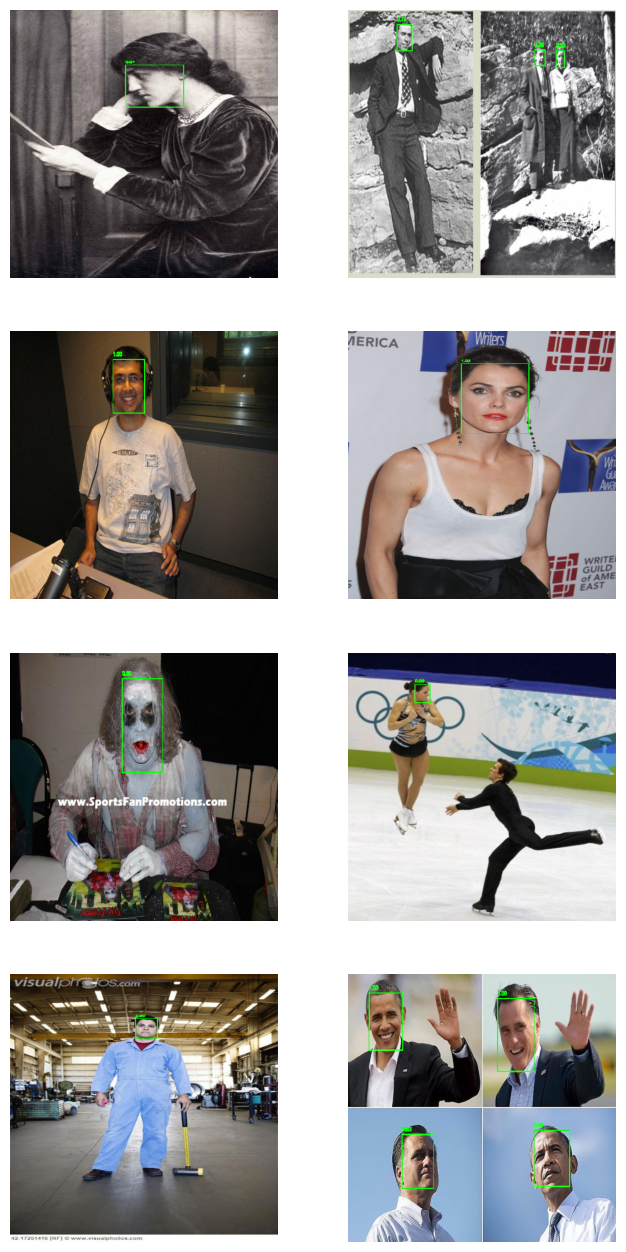

In [24]:
img_list=os.listdir(config.VAL_IMG_DIR)
img_idxs=np.random.choice(a=len(img_list)-1,size=8,replace=False)

fig,ax=plt.subplots(4,2,figsize=(8,16))
axes=ax.flatten()

for i,idx in enumerate(img_idxs):
    img_name=img_list[idx]
    img_pth=os.path.join(config.VAL_IMG_DIR,img_name)
    img=get_img_tensor(img_pth)
    prediction=img_inference(img_pth)
    annotated_img=face_detection_visualization(img,prediction)
    annotated_img=cv2.resize(annotated_img,(480,480))
    axes[i].imshow(annotated_img);
    axes[i].axis("off");

# Error Analysis

In [25]:
#error_report.py

def error_report(img_dir,img_annot_dir,savefile):
    columns=["index","tp","fp","fn"]
    data=[]
    dataset=FaceDetection(img_dir,img_annot_dir)
    for index in tqdm(range(len(dataset))):
        img,target=dataset[index]
        model=get_model()
        model_weights=config.OUTPUT_DIR_PYTORCH_WEIGHTS
        model.load_state_dict(torch.load(model_weights,map_location=config.device))
        
        model.eval()
        with torch.no_grad():
            prediction=model([img])[0]
        cleaned_prediction=nms_suppression_bbox(prediction)
        
        tp,fp,fn=confusion_matrix(target,cleaned_prediction)
        data.append([index,tp,fp,fn])
        
    report=pd.DataFrame(data=data,columns=columns)
    output_pth=os.path.join(config.OUTPUT_DIR_RESULTS,savefile)
    report.to_csv(output_pth,index=False)

def confusion_matrix(target,cleaned_prediction):
    gt_boxes=target["boxes"]
    pred_boxes=cleaned_prediction["boxes"]
        
    iou_matrix=box_iou_batch(gt_boxes,pred_boxes)
    iou_matrix=iou_matrix>0.5
        
    tp=torch.sum(iou_matrix).item()
    fp=max(0,len(pred_boxes)-tp)
    fn=max(0,len(gt_boxes)-tp)
    
    return tp,fp,fn

In [26]:
"""
This step takes around 4.5 hr and results are provided in face detection error analysis dataset
error_report(config.VAL_IMG_DIR,config.VAL_IMG_ANNOTATION,"error_report_val.csv")
"""

'\nThis step takes around 4.5 hr and results are provided in face detection error analysis dataset\nerror_report(config.VAL_IMG_DIR,config.VAL_IMG_ANNOTATION,"error_report_val.csv")\n'

In [27]:
results_df=pd.read_csv("/kaggle/input/face-detection-validation-dataset-error-analysis/error_report_val.csv")
results_df.head()

index  tp  fp  fn
0      0   5   0   0
1      1   1   0   0
2      2   5   0   0
3      3   3   0   0
4      4   3   1   3

In [28]:
tp=results_df["tp"].sum()
fp=results_df["fp"].sum()
fn=results_df["fn"].sum()

In [29]:
print(f"Number of True Positives: {tp}")
print(f"Number of False Positives: {fp}")
print(f"Number of False Negatives: {fn}")
print(f"Model Precision on Validation Dataset: {tp/(tp+fp):.4f}")
print(f"Model Recall on Validation Dataset: {tp/(tp+fn):.4f}")

Number of True Positives: 4376
Number of False Positives: 452
Number of False Negatives: 922
Model Precision on Validation Dataset: 0.9064
Model Recall on Validation Dataset: 0.8260


In [30]:
def target_prediction_visualization(index_list):
    dataset=FaceDetection(config.VAL_IMG_DIR,config.VAL_IMG_ANNOTATION)
    img_list=dataset.img_list
    
    img_idxs=np.random.choice(a=index_list,size=12,replace=False)
    
    fig,ax=plt.subplots(4,3,figsize=(12,16))
    axes=ax.flatten()
    
    for i,idx in enumerate(img_idxs):
        img_tensor,target=dataset[idx]
        img=np.transpose(img_tensor.cpu().numpy(),(1,2,0))
        img_name=img_list[idx]
        img_pth=os.path.join(config.VAL_IMG_DIR,img_name)
        prediction=img_inference(img_pth)
        annotated_img=error_visualization(img,target)
        error_img=error_visualization(annotated_img,prediction,(255,0,0))
        error_img=cv2.resize(error_img,(480,480))
        axes[i].imshow(error_img);
        axes[i].axis("off");
        axes[i].set_title(f"tp:{results_df.loc[idx,'tp']}  fp:{results_df.loc[idx,'fp']}  fn:{results_df.loc[idx,'fn']}")

def error_visualization(img,target,color=(0,255,0)):
    img_bbox=img.copy()
    try:
        boxes=target["boxes"].cpu().numpy().astype("int")
        for i,box in enumerate(boxes):
            cv2.rectangle(img_bbox,(box[0],box[1]),(box[2],box[3]),color,4)
    except:
        print("No Face Detected in the image\n")
        
    return img_bbox

## False Positive
- **Negative instances(not face) that are identified as positive instances(face)**

In [31]:
results_df_fp=results_df.sort_values(by="fp",ascending=False)
fp_index_list=results_df_fp.head(20).index.values

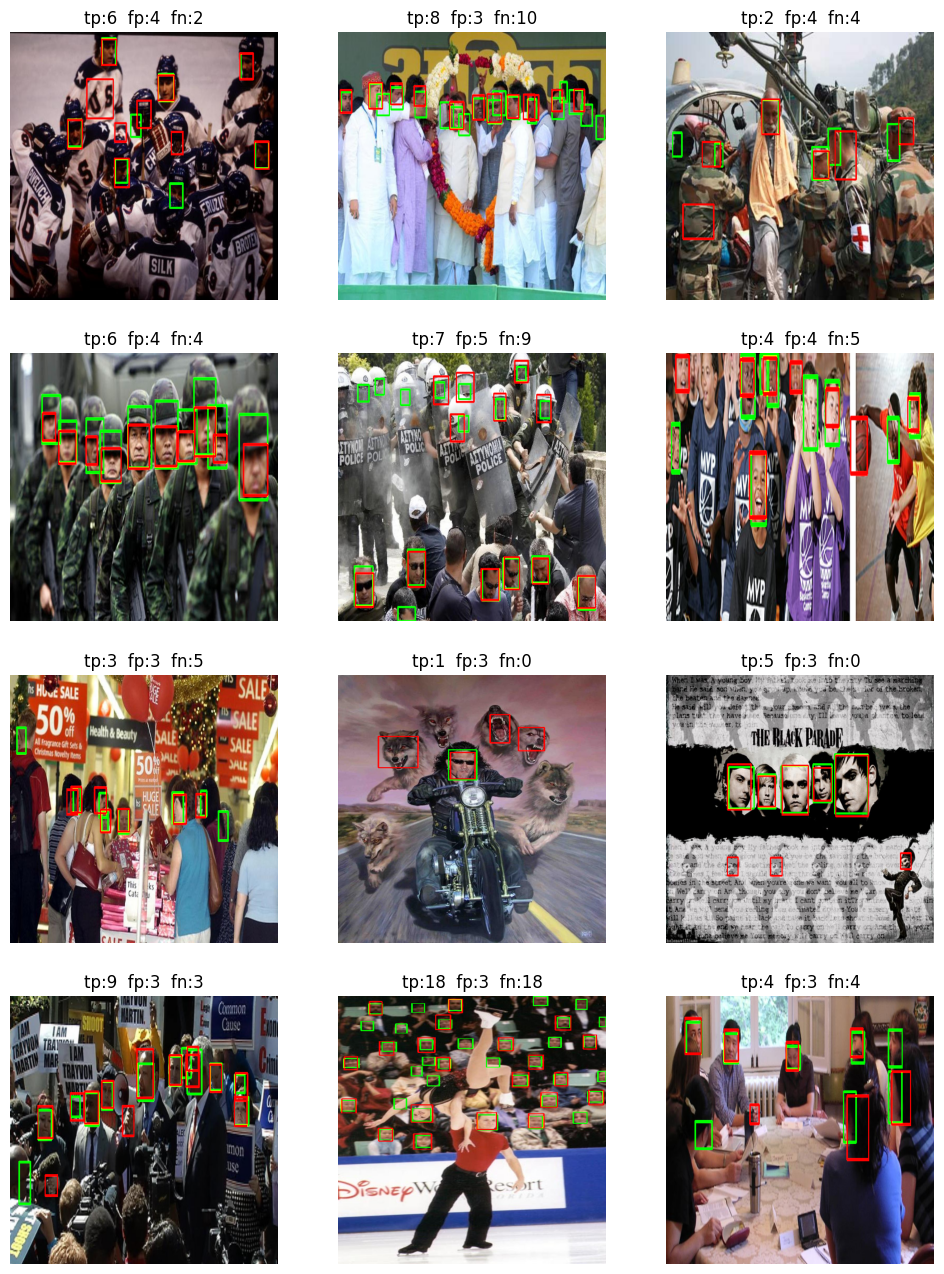

In [32]:
target_prediction_visualization(fp_index_list)

## False Negative
- **Positive instances(face) that model fails to identify as positive instances(face)**

In [33]:
results_df_fn=results_df.sort_values(by="fn",ascending=False)
fn_index_list=results_df_fn.head(40).index.values

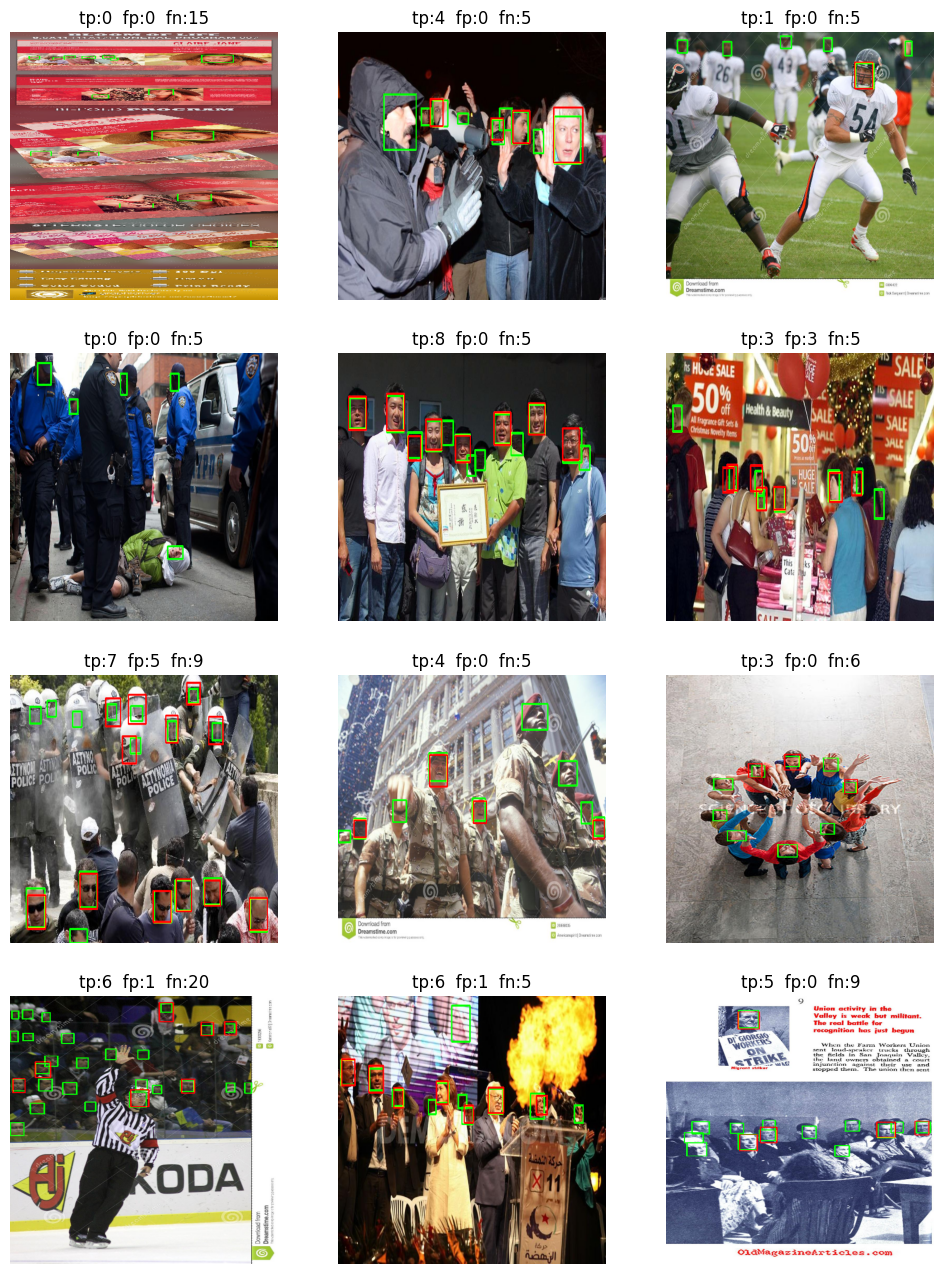

In [34]:
target_prediction_visualization(fn_index_list)

In [35]:
! rm -rf "/kaggle/working/data"